In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

/Users/1X/Library/Python/3.8/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


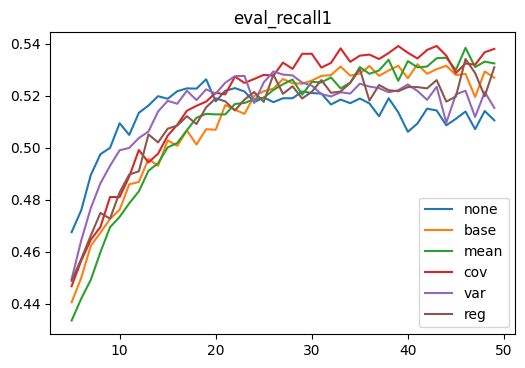

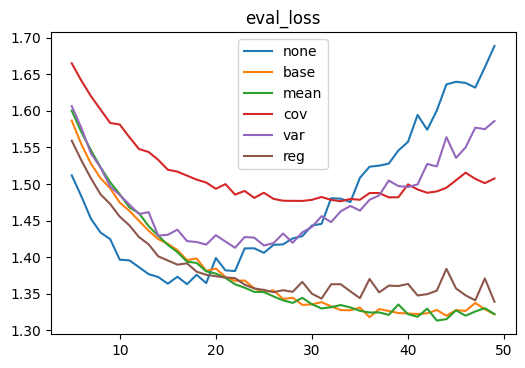

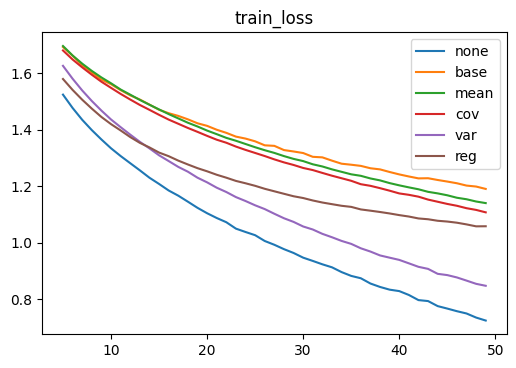

In [54]:
#group, tags = "test", ("none", "base", "mean", "cov", "var", "reg")
group, tags = "layers", ("l", "l1", "l2", "l3", "l12", "l13", "l23", "l123")

df_map = {}
for tag in tags:
    try:
        df_map[tag] = pd.read_json(f"outputs/{group}/{tag}_1/logs.json")
    except:
        pass

def plot(key, start=5):
    _, ax = plt.subplots(1, 1, facecolor="w", dpi=100)
    ax.set_title(key)
    for tag, df in df_map.items():
        df[df.index >= start][key].plot(ax=ax, label=tag,)
    ax.legend()

plot(f"eval_recall1")
plot(f"eval_loss")
plot(f"train_loss")
'''
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.weight.l2")
for i in (2, 6, 10, 14):
    plot(f"eval_${i}.bias.l2")
'''
None

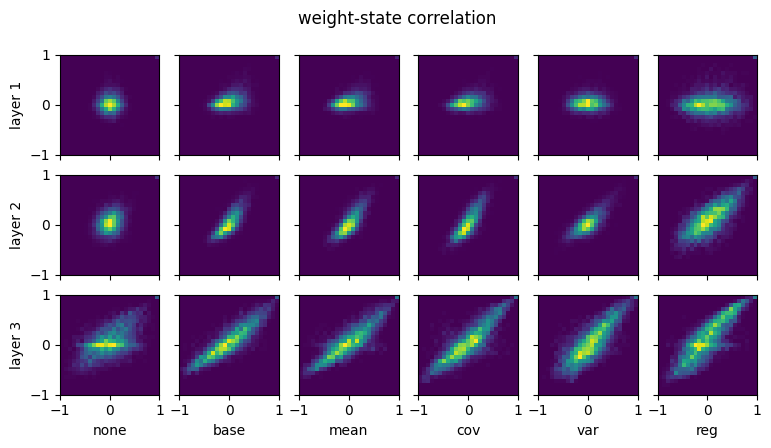

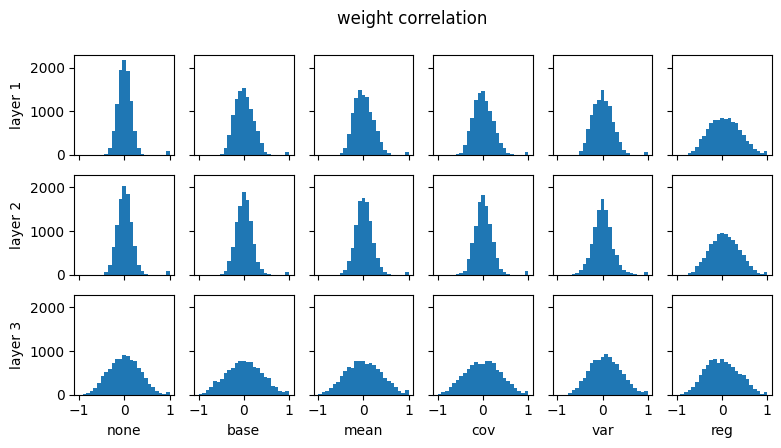

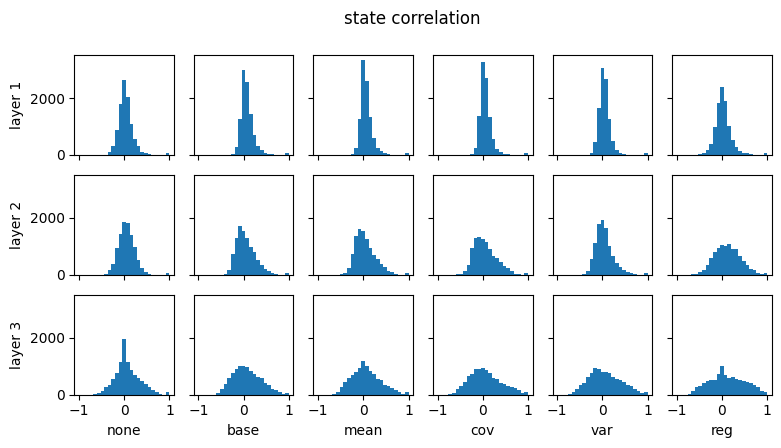

In [63]:
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def corr(m1, m2):
    sd = (m2.diagonal() - m1.square()).clip(min=0).sqrt()
    return (m2 - outer(m1)) / outer(sd)

def cov(m1, m2):
    return m2 - outer(m1)

def read_state(state, i, training):
    mode = "train" if training else "eval"
    num = state[f"{i}.{mode}_num"]
    sum = state[f"{i}.{mode}_sum"]
    sum_sq = state[f"{i}.{mode}_sum_sq"]
    return sum / num, sum_sq / num

def read_weight(state, i, transpose):
    w = state[f"{i}.weight"]
    if transpose:
        w = w.T
    return w.mean(1), w @ w.T

def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

#group, tags = "test", ("none", "base", "mean", "cov", "var", "reg")
group, tags = "layers", ("l", "l1", "l2", "l3", "l12", "l13", "l23", "l123")
layers = [f"layer {i+1}" for i in range(3)]
epoch = 50
#term, ranges, fn = "corss-prod", ((-1/3, 1/3), (0, 2/3)), lambda m1, m2: m2
#term, ranges, fn = "covariance", ((-1/4, 1/4), (-1/4, 1/4)), cov
term, ranges, fn = "correlation", ((-1, 1), (-1, 1)), corr

ax_xy = gridplot(f"weight-state {term}", tags, layers)
ax_x = gridplot(f"weight {term}", tags, layers)
ax_y = gridplot(f"state {term}", tags, layers)
for i, tag in enumerate(tags):
    state = torch.load(f"outputs/{group}/{tag}_1/checkpoint-{epoch}.pt")
    for j in range(3):
        #w_m1, w_m2 = read_weight(state["model"], j*4+2, False)
        w_m1, w_m2 = read_weight(state["model"], j*4+6, True)
        s_m1, s_m2 = read_state(state["model"], j*4+4, True)
        x = fn(w_m1, w_m2)
        y = fn(s_m1, s_m2)
        x = x.flatten().numpy()
        y = y.flatten().numpy()
        ax_xy[j][i].hist2d(x, y, bins=(25, 25), range=ranges)
        ax_x[j][i].hist(x, bins=25, range=ranges[0])
        ax_y[j][i].hist(y, bins=25, range=ranges[1])